In [1]:
#Packages
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import sklearn.datasets as skld
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn

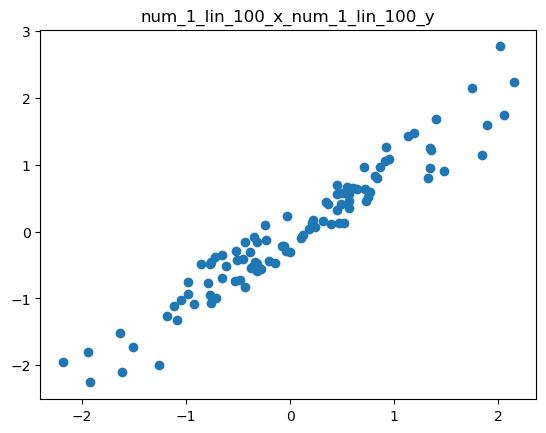

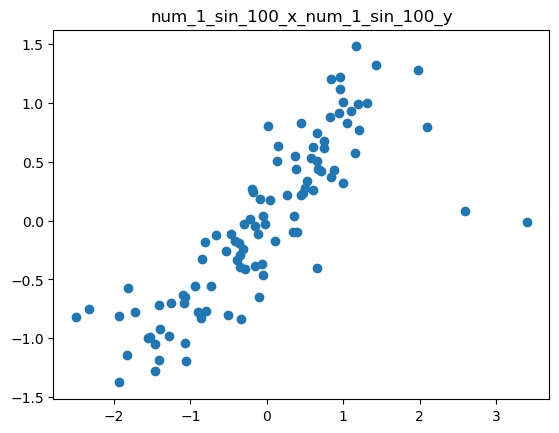

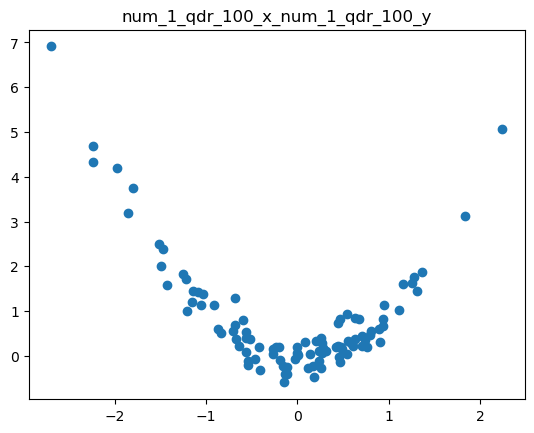

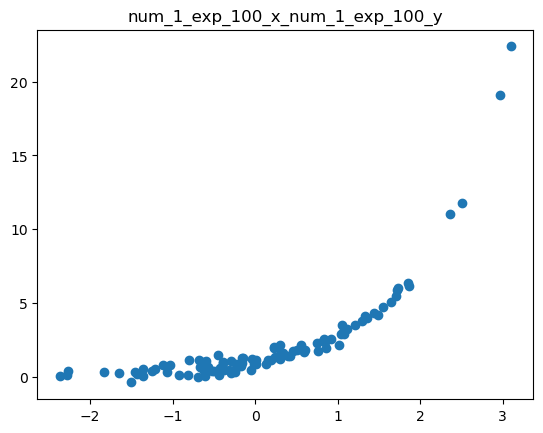

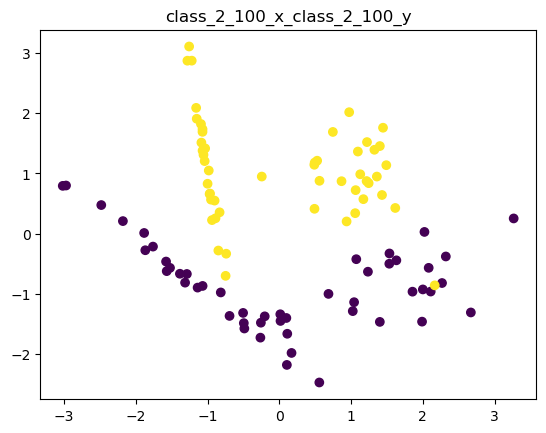

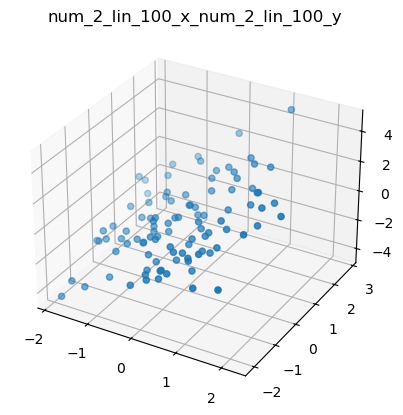

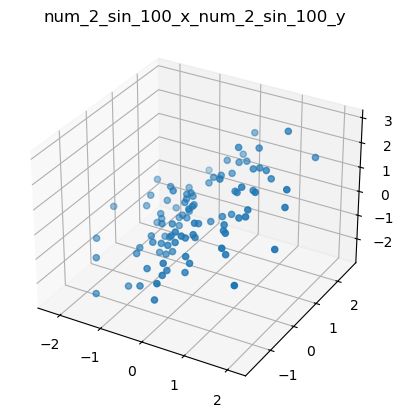

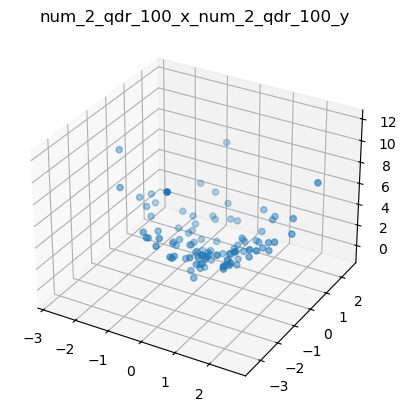

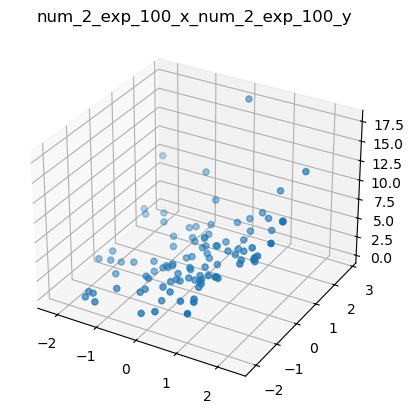

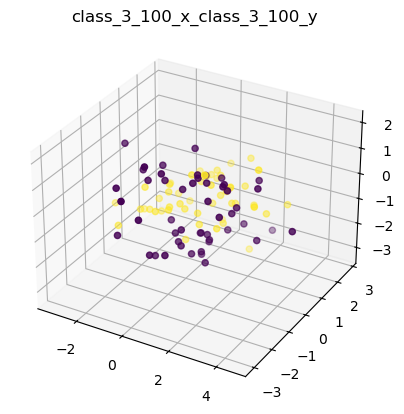

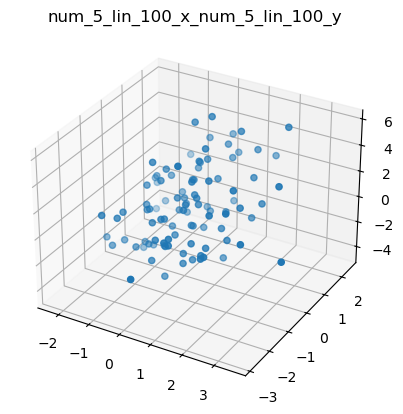

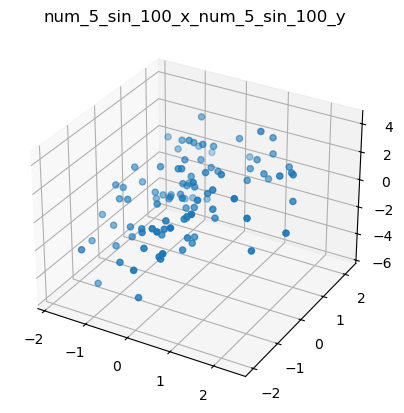

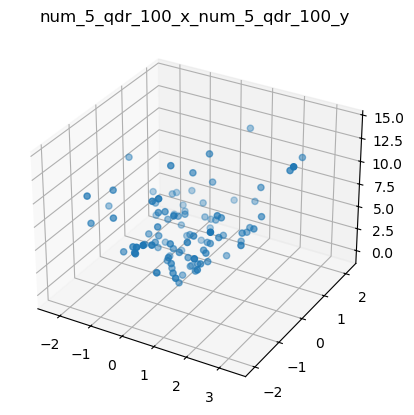

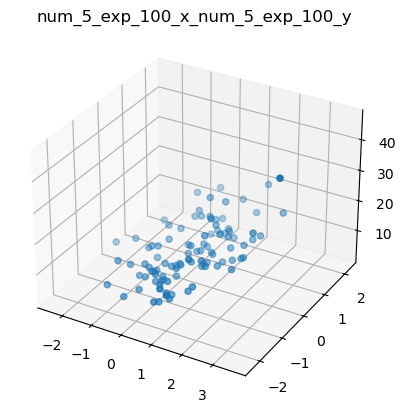

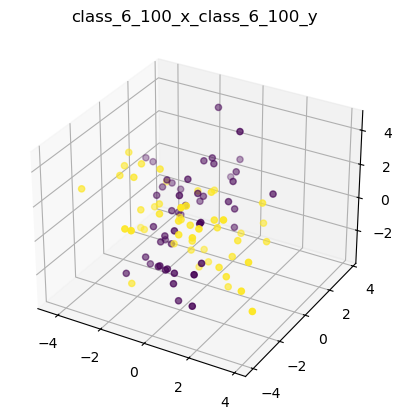

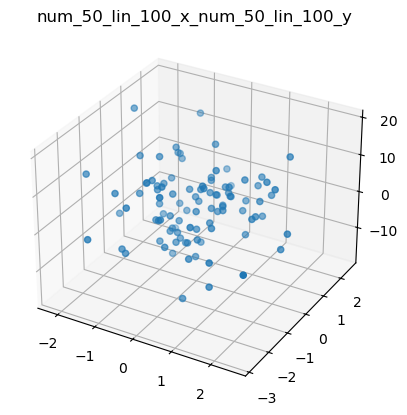

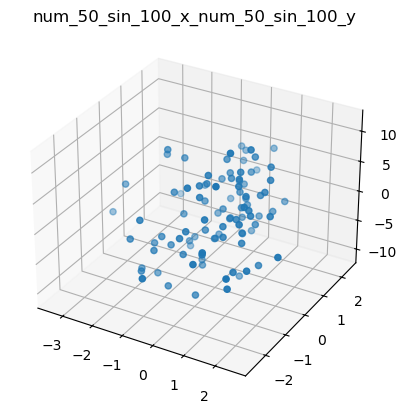

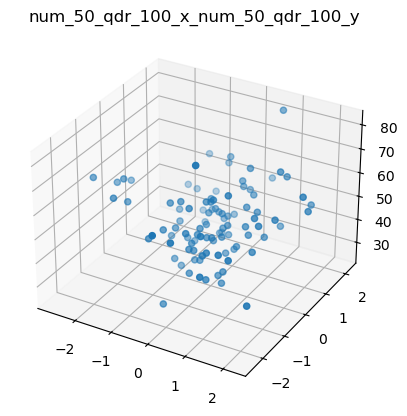

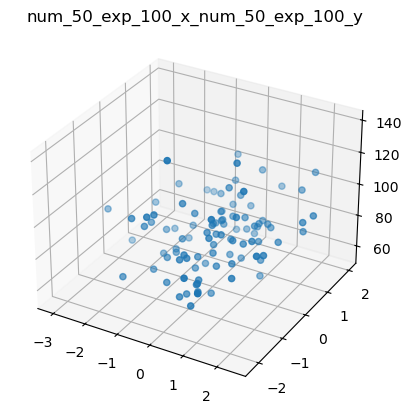

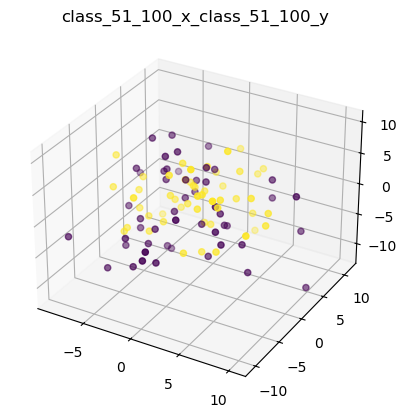

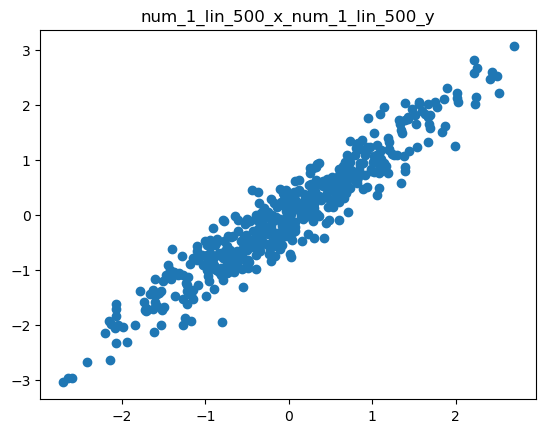

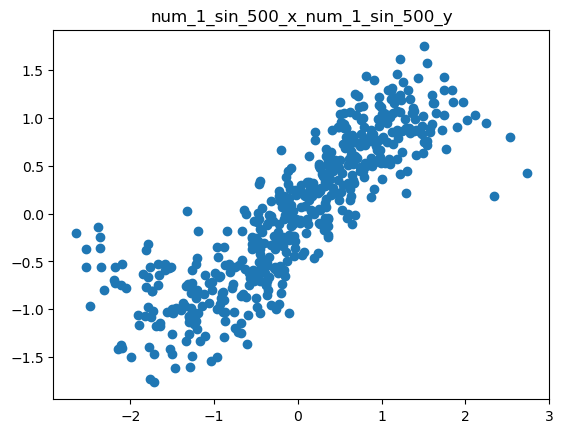

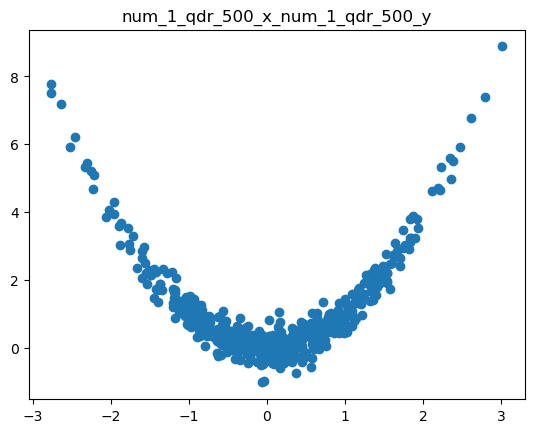

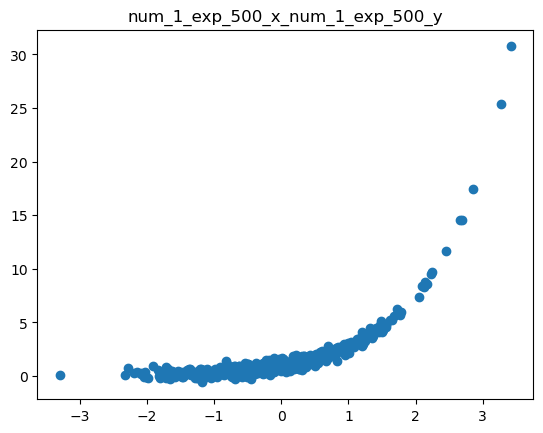

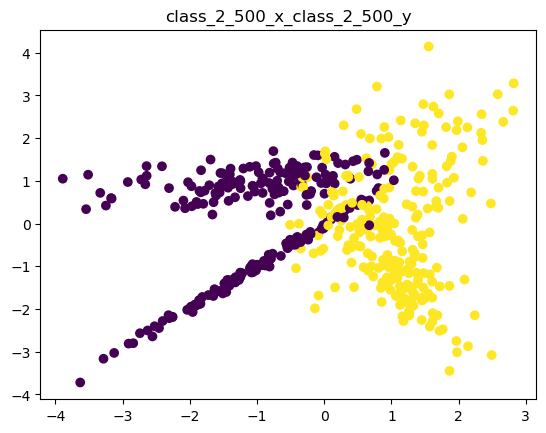

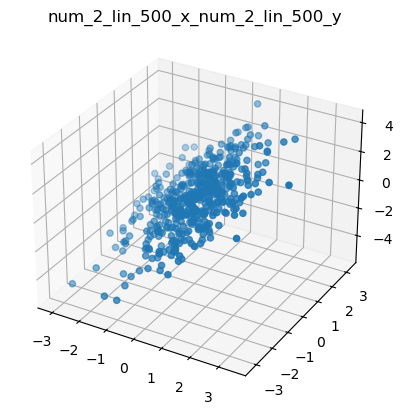

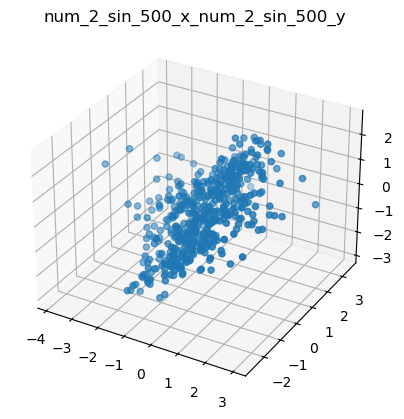

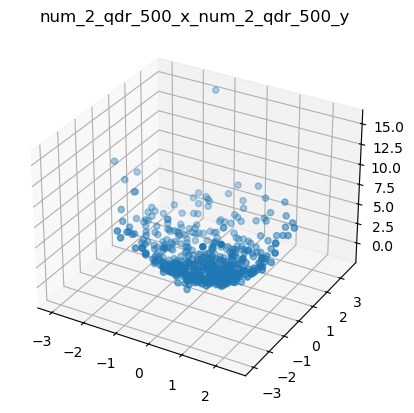

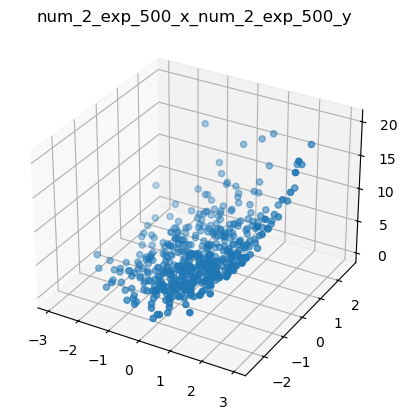

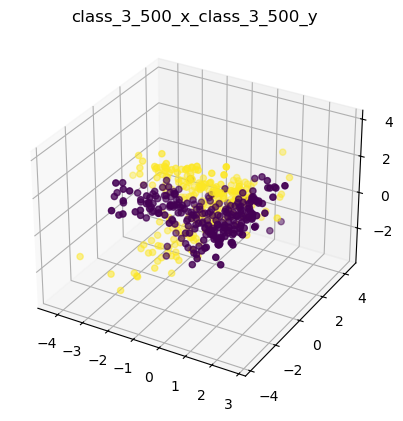

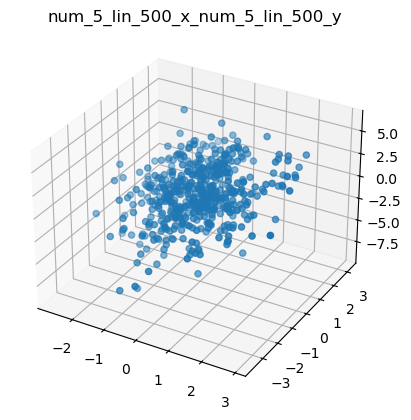

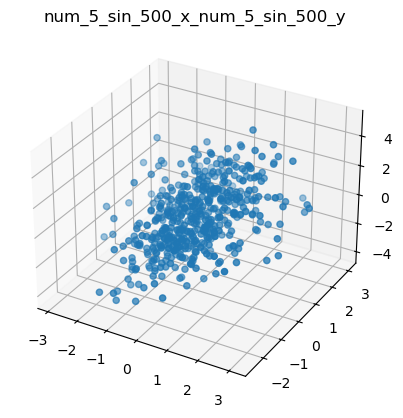

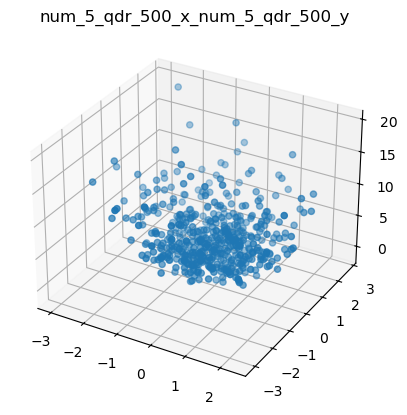

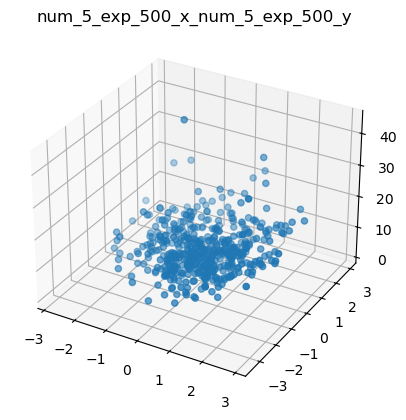

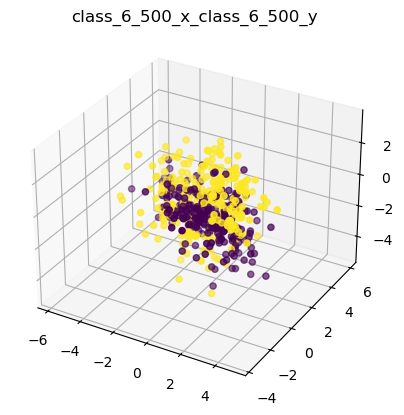

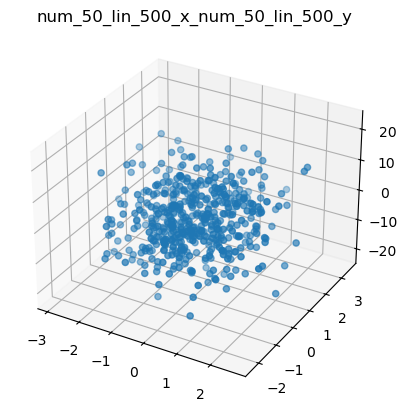

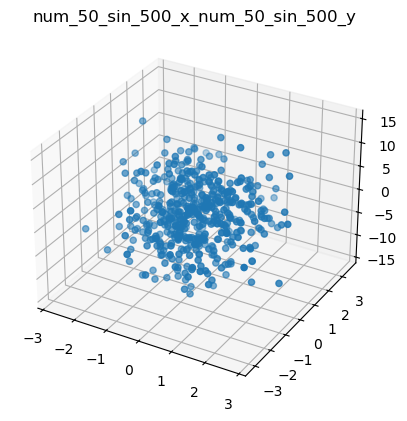

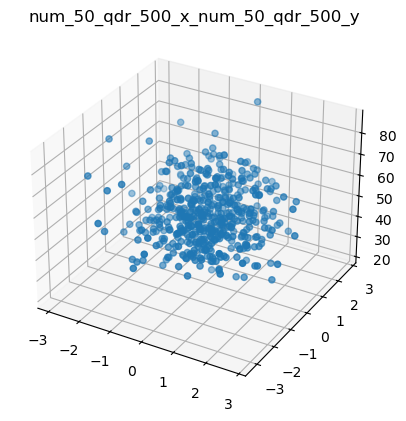

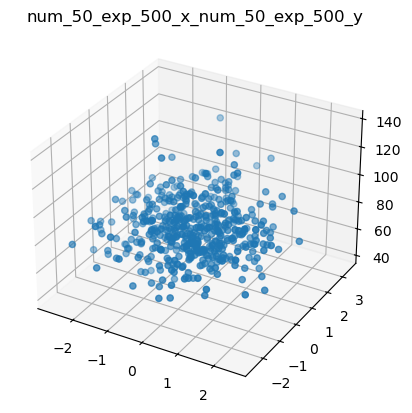

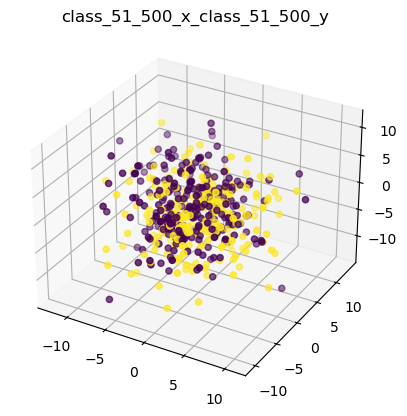

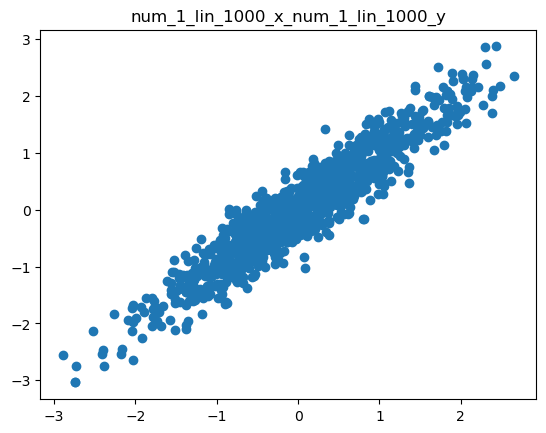

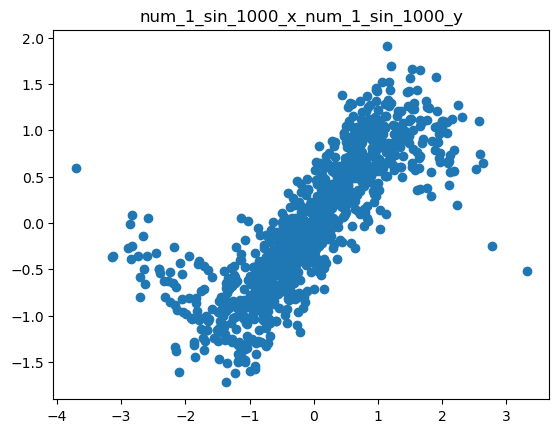

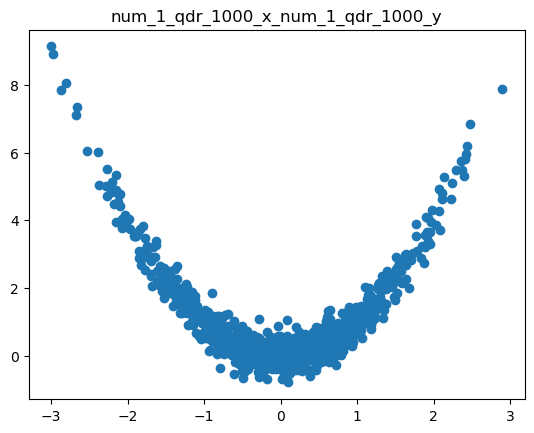

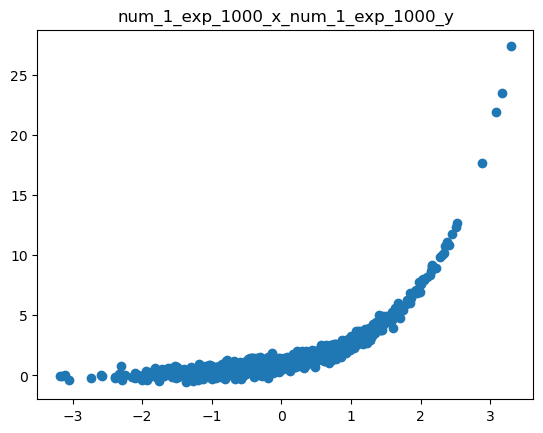

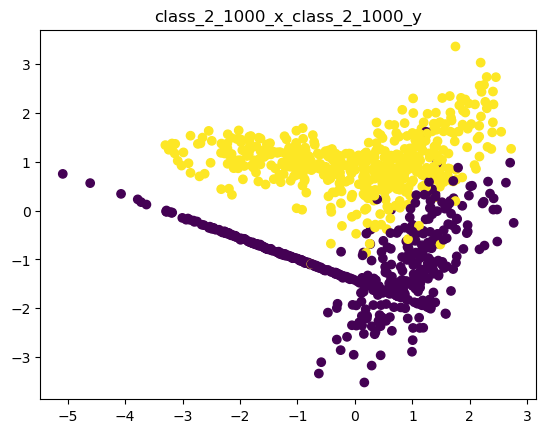

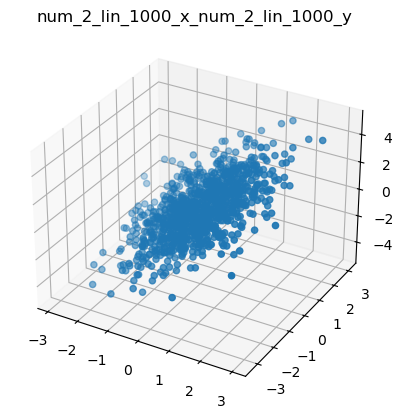

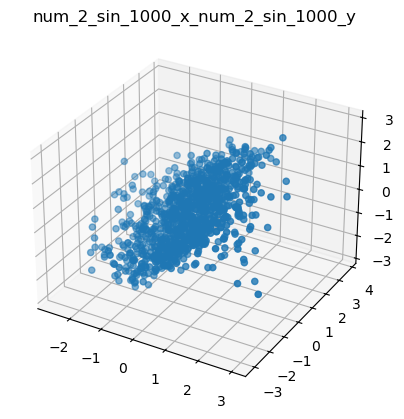

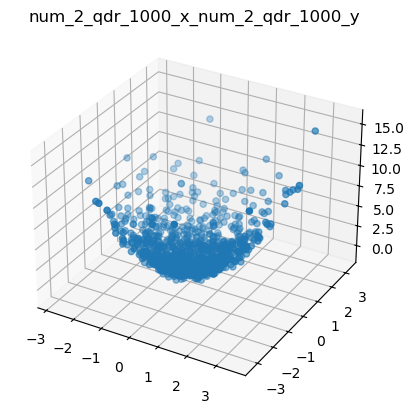

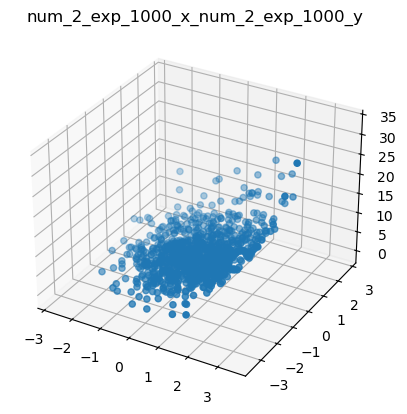

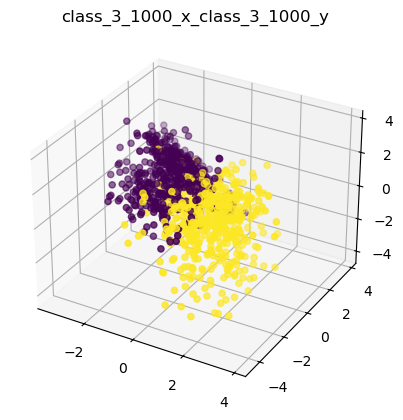

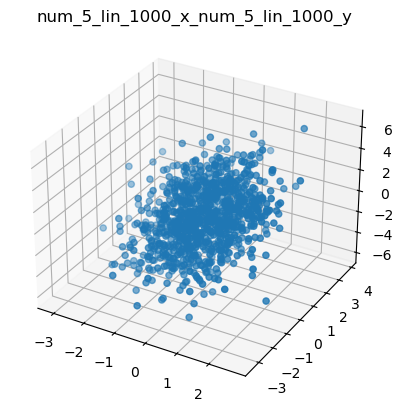

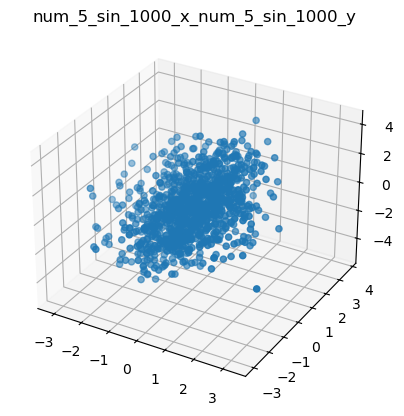

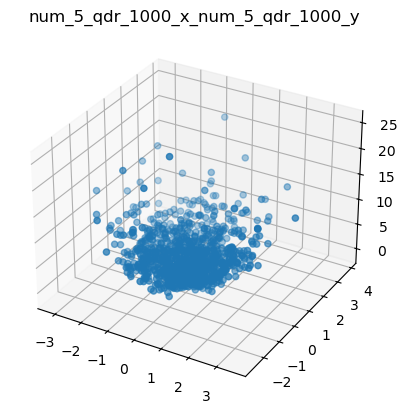

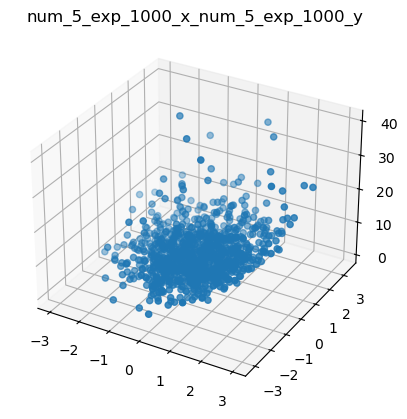

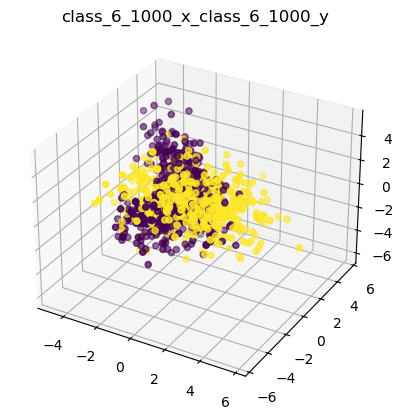

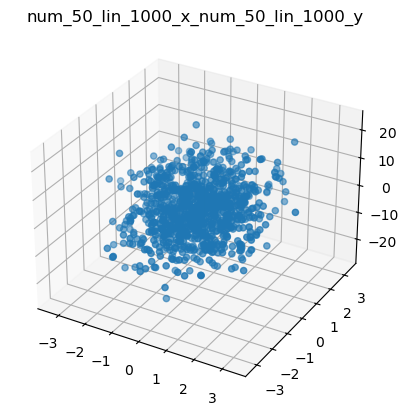

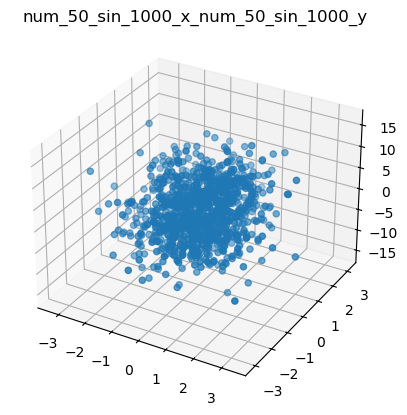

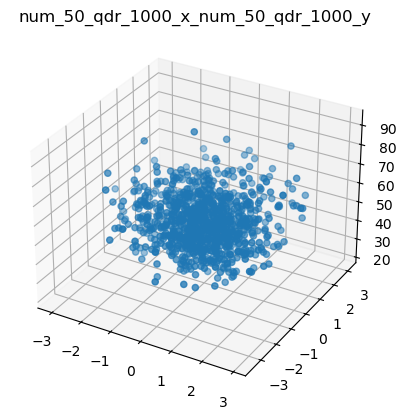

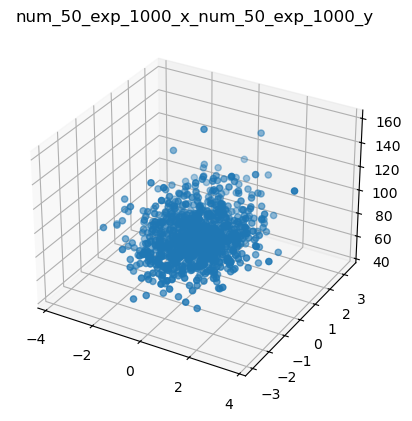

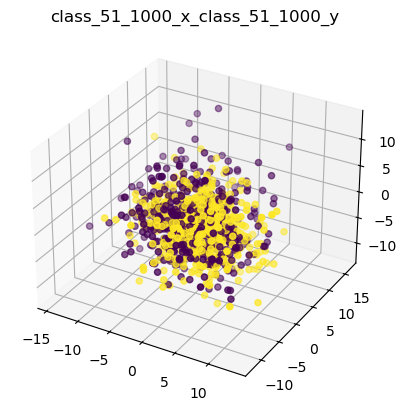

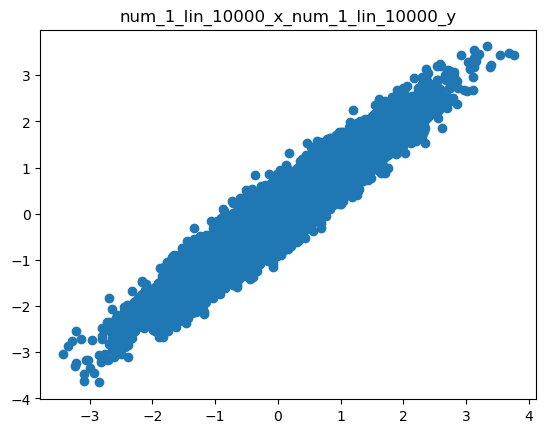

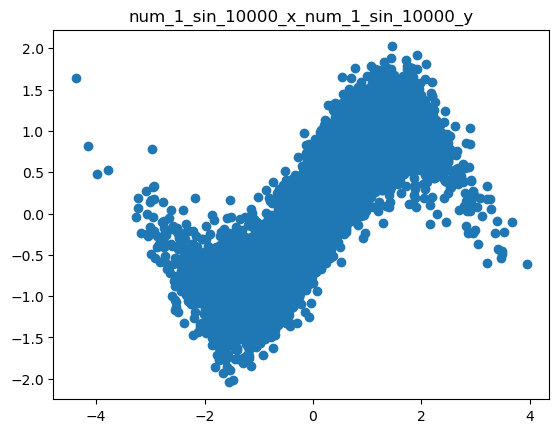

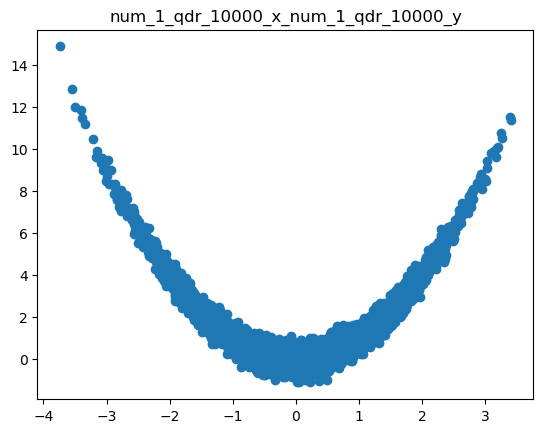

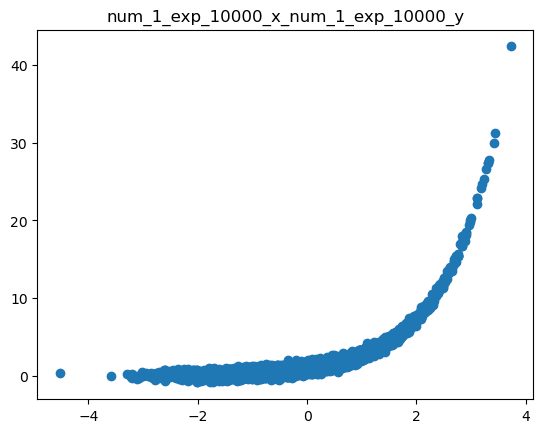

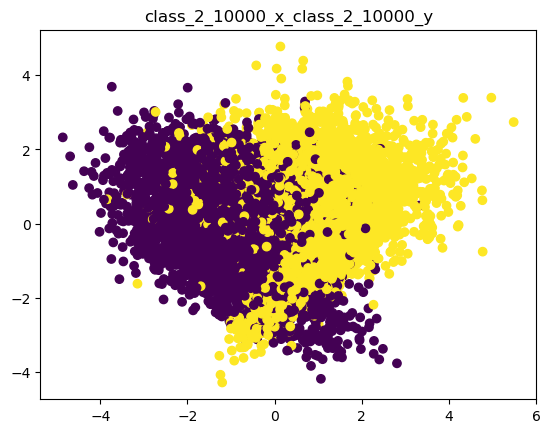

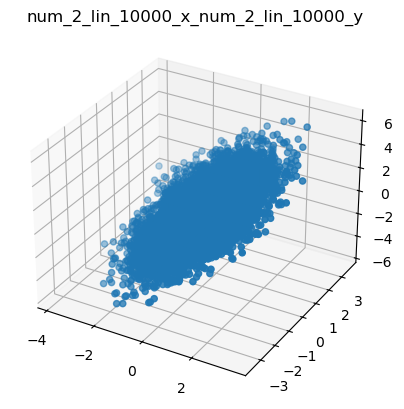

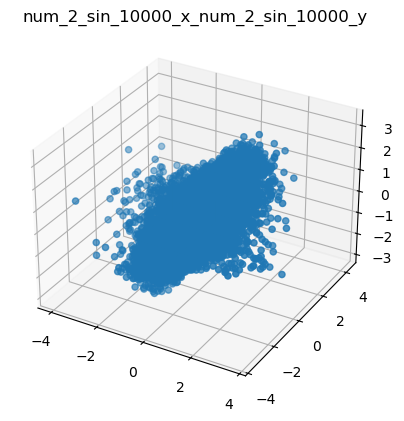

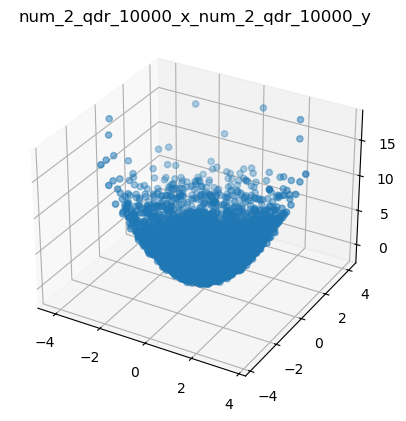

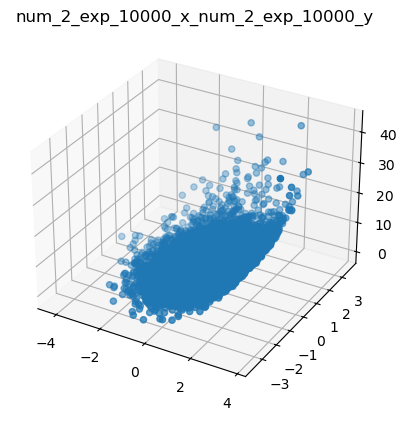

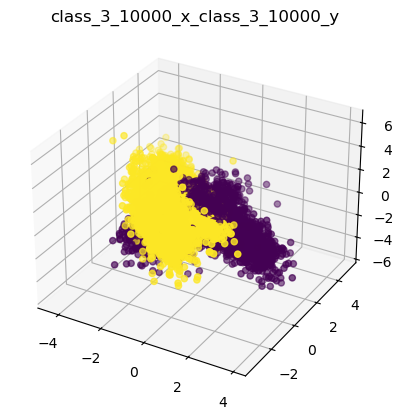

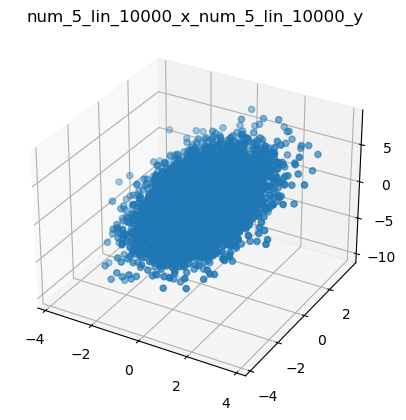

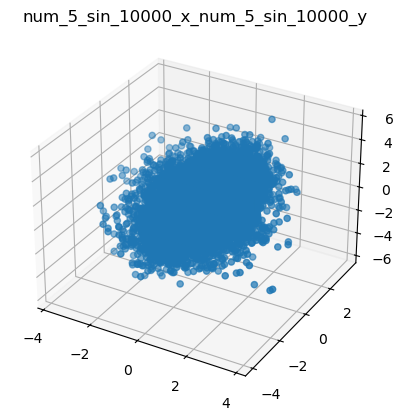

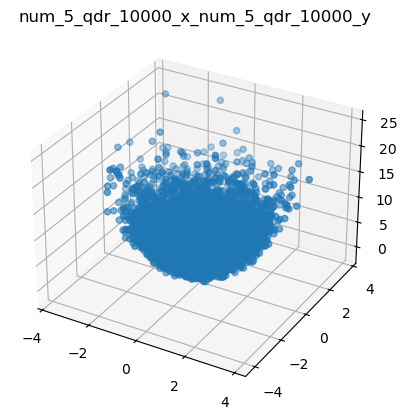

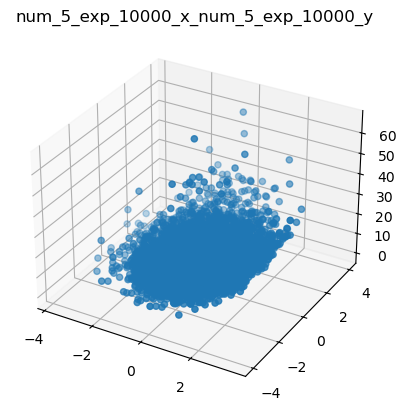

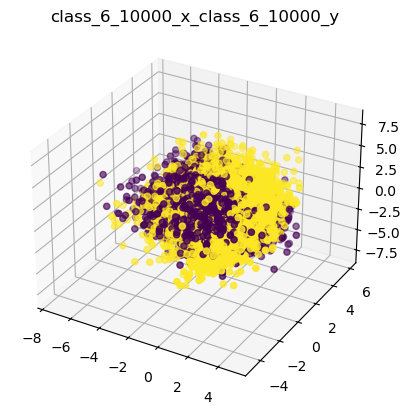

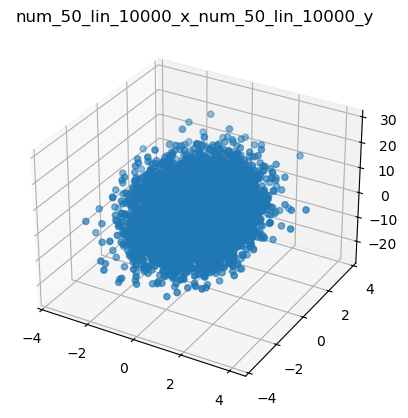

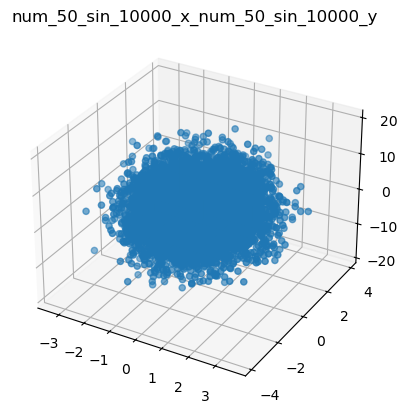

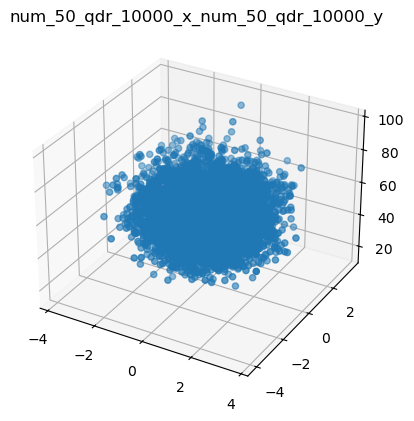

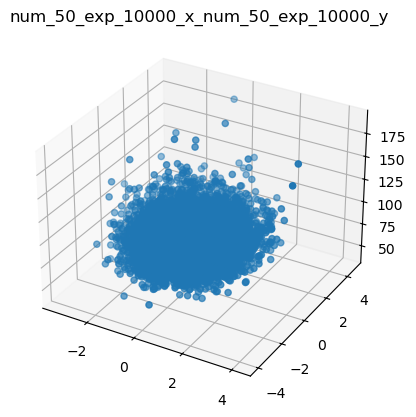

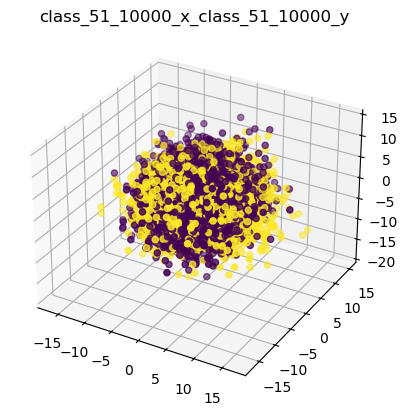

In [25]:
#Data generation

np.random.seed(13)

N = [100, 500, 1000, 10000]
D = [1, 2, 5, 50] #will be d+1 for classification
#y_d = [1, 2, 5, 10] Ignoring these for now, think just simple 1 dim outcome for numeric and 2 classes for 
#y_c = [2, 3, 5, 10]
num_rel = ['lin', 'sin', 'qdr', 'exp']
error = 0.1

datasets = {} #Dictionary of datasets
#Loops to make and plot datasets
for n in N:
    for d in D:
        for n_r in num_rel:

            #Numeric datasets
            data_name = f"num_{d}_{n_r}_{n}_x"
            y_name = f"num_{d}_{n_r}_{n}_y"

            datasets[data_name] = np.random.multivariate_normal(mean = np.zeros(d), cov = np.identity(d), size = n)
            errors = np.random.multivariate_normal(mean = np.zeros(d), cov = error * np.identity(d), size = n)
            if d == 1:
                if n_r == 'lin':
                    #Linear case
                    datasets[y_name] = datasets[data_name] + errors
                if n_r == 'sin':
                    #Sinusoidal case
                    datasets[y_name] = np.sin(datasets[data_name]) + errors
                if n_r == 'qdr':
                    #Quadratic case
                    datasets[y_name] = datasets[data_name] ** 2 + errors
                if n_r == 'exp':
                    #Exponential case
                    datasets[y_name] = np.exp(datasets[data_name]) + errors
                    
                plt.scatter(datasets[data_name], datasets[y_name])
                plt.title(f"{data_name}_{y_name}")
                plt.show()
                
            else:
                if n_r == 'lin':
                    #Linear case
                    datasets[y_name] = np.sum(datasets[data_name], axis = 1) + np.sum(errors, axis = 1)
                if n_r == 'sin':
                    #Sinusoidal case
                    datasets[y_name] = np.sum(np.sin(datasets[data_name]), axis = 1) + np.sum(errors, axis = 1)
                if n_r == 'qdr':
                    #Quadratic case
                    datasets[y_name] = np.sum(datasets[data_name] ** 2, axis = 1) + np.sum(errors, axis = 1)
                if n_r == 'exp':
                    #Exponential case
                    datasets[y_name] = np.sum(np.exp(datasets[data_name]), axis = 1) + np.sum(errors, axis = 1)
                fig = plt.figure()
                ax = fig.add_subplot(projection='3d')
                ax.scatter(datasets[data_name][:, 0], datasets[data_name][:, 1], datasets[y_name]) #For dimensions > 1
                ax.set_title(f"{data_name}_{y_name}")
                plt.show()
        #Now classification datasets
        data_name = f"class_{d+1}_{n}_x"
        y_name = f"class_{d+1}_{n}_y"
        datasets[data_name], datasets[y_name] = skld.make_classification(n_samples = n, n_features = d+1, 
                                                                         n_redundant = 0, n_informative = d+1, 
                                                                         n_classes = 2, class_sep = 1, random_state = 13)
        if d == 1:
            plt.scatter(datasets[data_name][:, 0], datasets[data_name][:, 1], c = datasets[y_name])
            plt.title(f"{data_name}_{y_name}")
            plt.show()
        else:
            fig = plt.figure()
            ax = fig.add_subplot(projection='3d')
            scatter = ax.scatter(datasets[data_name][:, 0], datasets[data_name][:, 1], datasets[data_name][:, 2], c=datasets[y_name])
            ax.set_title(f"{data_name}_{y_name}")
            plt.show()

In [26]:
#Neural Network Definitions
#Classification function NN
class class_NN_ReLU(nn.Module):
    def __init__(self, n_dim_x = 2, n_class_y = 1, depth = 1, width = 2): #Specifications for input data form and neural network form
        super(class_NN_ReLU, self).__init__()
        layers = []
        #Input layer
        layers.append(nn.Linear(n_dim_x, width))
        layers.append(nn.ReLU())
        #Hidden layers
        for _ in range(depth - 1):
            layers.append(nn.Linear(width, width))
            layers.append(nn.ReLU())
        #Output layer; Allows for multiple class probability, make sure to use cross-entropy loss when evaluating criterion
        layers.append(nn.Linear(width, n_class_y))
        
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x) #Provides raw logits for use in cross-entropy loss

#Numeric function NN - Don't think is needed, see if others work with numeric data?
class numeric_NN_ReLU(nn.Module):
    def __init__(self, n_dim_x = 2, n_dim_y = 1, depth = 1, width = 2):
        super(numeric_NN_ReLU, self).__init__()
        layers = []
        #Input layer
        layers.append(nn.Linear(n_dim_x, width))
        layers.append(nn.ReLU())
        #Hidden layers
        for _ in range(depth - 1):
            layers.append(nn.Linear(width, width))
            layers.append(nn.ReLU())
        #Output layer
        layers.append(nn.Linear(width, n_dim_y))
        
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


class class_NN_LeakyReLU(nn.Module):
    def __init__(self, n_dim_x = 2, n_class_y = 1, depth = 1, width = 2): #Specifications for input data form and neural network form
        super(class_NN_LeakyReLU, self).__init__()
        layers = []
        #Input layer
        layers.append(nn.Linear(n_dim_x, width))
        layers.append(nn.LeakyReLU())
        #Hidden layers
        for _ in range(depth - 1):
            layers.append(nn.Linear(width, width))
            layers.append(nn.LeakyReLU())
        #Output layer; Allows for multiple class probability, make sure to use cross-entropy loss when evaluating criterion
        layers.append(nn.Linear(width, n_class_y))
        
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


class class_NN_ELU(nn.Module): #CeLU looked very similar on pytorch documentation, we can try both but I'm not sure ther will be a huge difference
    def __init__(self, n_dim_x = 2, n_class_y = 1, depth = 1, width = 2): #Specifications for input data form and neural network form
        super(class_NN_ELU, self).__init__()
        layers = []
        #Input layer
        layers.append(nn.Linear(n_dim_x, width))
        layers.append(nn.ELU())
        #Hidden layers
        for _ in range(depth - 1):
            layers.append(nn.Linear(width, width))
            layers.append(nn.ELU())
        #Output layer; Allows for multiple class probability, make sure to use cross-entropy loss when evaluating criterion
        layers.append(nn.Linear(width, n_class_y))
        
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


class class_NN_PReLU(nn.Module): # documentation recommends not using weight decay with this training
    def __init__(self, n_dim_x = 2, n_class_y = 1, depth = 1, width = 2): #Specifications for input data form and neural network form
        super(class_NN_PReLU, self).__init__()
        layers = []
        #Input layer
        layers.append(nn.Linear(n_dim_x, width))
        layers.append(nn.PReLU())
        #Hidden layers
        for _ in range(depth - 1):
            layers.append(nn.Linear(width, width))
            layers.append(nn.PReLU())
        #Output layer; Allows for multiple class probability, make sure to use cross-entropy loss when evaluating criterion
        layers.append(nn.Linear(width, n_class_y))
        
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


class class_NN_SELU(nn.Module):
    def __init__(self, n_dim_x = 2, n_class_y = 1, depth = 1, width = 2): #Specifications for input data form and neural network form
        super(class_NN_SELU, self).__init__()
        layers = []
        #Input layer
        layers.append(nn.Linear(n_dim_x, width))
        layers.append(nn.SELU())
        #Hidden layers
        for _ in range(depth - 1):
            layers.append(nn.Linear(width, width))
            layers.append(nn.SELU())
        #Output layer; Allows for multiple class probability, make sure to use cross-entropy loss when evaluating criterion
        layers.append(nn.Linear(width, n_class_y))
        
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)
        

class class_NN_ALReLU(nn.Module): # adjust this one into ALReLU? Ohhh isn't working rn
    def __init__(self, n_dim_x = 2, n_class_y = 1, depth = 1, width = 2): #Specifications for input data form and neural network form
        super(class_NN_ALReLU, self).__init__()
        layers = []
        #Input layer
        layers.append(nn.Linear(n_dim_x, width))
        layers.append(nn.ALReLU())
        #Hidden layers
        for _ in range(depth - 1):
            layers.append(nn.Linear(width, width))
            layers.append(nn.ALReLU())
        #Output layer; Allows for multiple class probability, make sure to use cross-entropy loss when evaluating criterion
        layers.append(nn.Linear(width, n_class_y))
        
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [27]:
#Test for numeric data

train_x, test_x, train_y, test_y = train_test_split(datasets["num_1_lin_100_x"], datasets["num_1_lin_100_x"],
                                                    test_size = 0.2, random_state = 13)
scaler = StandardScaler() #Scaling stuff
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

train_x_tensor = torch.tensor(train_x, dtype=torch.float32) #Making stuff tensors (?)
train_y_tensor = torch.tensor(train_y, dtype=torch.float32)
test_x_tensor = torch.tensor(test_x, dtype=torch.float32)
test_y_tensor = torch.tensor(test_y, dtype=torch.float32)

model = class_NN_ReLU(n_dim_x=1, n_class_y=1, depth=1, width=4) #Model specifications and stuff
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 100 #Training? IDK copied from chat
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_x_tensor)
    loss = criterion(outputs, train_y_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

model.eval()
with torch.no_grad():
    y_pred = model(test_x_tensor)
    mse = nn.MSELoss()(y_pred, test_y_tensor)
    print(f"Test MSE: {mse.item():.4f}")

    y_pred_np = y_pred.numpy()
#Ok so it works for classification and numeric, no need to differentiate/create dif ones

Epoch [10/100], Loss: 0.3054
Epoch [20/100], Loss: 0.1314
Epoch [30/100], Loss: 0.0327
Epoch [40/100], Loss: 0.0090
Epoch [50/100], Loss: 0.0123
Epoch [60/100], Loss: 0.0075
Epoch [70/100], Loss: 0.0059
Epoch [80/100], Loss: 0.0055
Epoch [90/100], Loss: 0.0049
Epoch [100/100], Loss: 0.0045
Test MSE: 0.0091


In [44]:
#Loop for Neural Network training for each dataset

#Redefining stuff just in case
N = [100, 500]#, 1000, 10000]
D = [1, 2, 5]#, 50] #will be d+1 for classification
num_rel = ['lin', 'sin', 'qdr', 'exp']
error = 0.1

avg_loss = {}
avg_speed = {}

#NN pars and stuff
activs = ["ReLU", "Leaky_ReLU", "ELU", "PReLU", "SELU"]#, "ALReLU"]
depths = [1, 3, 10]#, 20, 30] #Also shortening the depth list lol
iters_per = 5
max_iters = 10

for n in N:
    for d in D:
        #Numeric training
        criterion = nn.MSELoss()
        for n_r in num_rel:
            
            data_x = datasets[f"num_{d}_{n_r}_{n}_x"]
            data_y = datasets[f"num_{d}_{n_r}_{n}_y"]
            train_x, test_x, train_y, test_y = train_test_split(data_x, data_y,
                                                    test_size = 0.2)
            scaler = StandardScaler() #Scaling stuff
            train_x = scaler.fit_transform(train_x)
            test_x = scaler.transform(test_x)
            
            train_x_tensor = torch.tensor(train_x, dtype=torch.float32) #Making stuff tensors (?)
            train_y_tensor = torch.tensor(train_y, dtype=torch.float32)
            test_x_tensor = torch.tensor(test_x, dtype=torch.float32)
            test_y_tensor = torch.tensor(test_y, dtype=torch.float32)
            for i in depths:
                for activ in activs:
                    if activ == "ReLU":
                        model = class_NN_ReLU(n_dim_x = d, n_class_y = 1, depth = i, width = 8) #Can change width at some point if desired
                    if activ == "Leaky_ReLU":
                        model = class_NN_LeakyReLU(n_dim_x = d, n_class_y = 1, depth = i, width = 8)
                    if activ == "ELU":
                        model = class_NN_ELU(n_dim_x = d, n_class_y = 1, depth = i, width = 8)
                    if activ == "PReLU":
                        model = class_NN_PReLU(n_dim_x = d, n_class_y = 1, depth = i, width = 8)
                    if activ == "SELU":
                        model = class_NN_SELU(n_dim_x = d, n_class_y = 1, depth = i, width = 8)
                    if activ == "ALReLU":
                        model = class_NN_ALReLU(n_dim_x = d, n_class_y = 1, depth = i, width = 8)
                    optimizer = optim.Adam(model.parameters(), lr = 0.01)

                    mini_losses = []
                    for _ in range(iters_per):
                        for epoch in range(max_iters):
                            model.train()
                            optimizer.zero_grad()
                            outputs = model(train_x_tensor)
                            loss = criterion(outputs, train_y_tensor)
                            loss.backward()
                            optimizer.step()
                            
                            #if (epoch+1) % 10 == 0: Do NOT want to print all this lol
                                #print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
                    
                        model.eval()
                        with torch.no_grad():
                            y_pred = model(test_x_tensor)
                            mse = nn.MSELoss()(y_pred, test_y_tensor)
                            mini_losses.append(mse)
                    avg_loss[f"num_{d}_{n_r}_{n}_{activ}_{i}_mse"] = np.array(mini_losses)
                    
        #Classification training
        criterion = nn.CrossEntropyLoss()
        data_x = datasets[f"class_{d+1}_{n}_x"]
        data_y = datasets[f"class_{d+1}_{n}_y"]

        train_x, test_x, train_y, test_y = train_test_split(data_x, data_y,
                                                            test_size = 0.2)
        scaler = StandardScaler() #Scaling stuff
        train_x = scaler.fit_transform(train_x)
        test_x = scaler.transform(test_x)
            
        train_x_tensor = torch.tensor(train_x, dtype=torch.float32) #Making stuff tensors (?)
        train_y_tensor = torch.tensor(train_y, dtype=torch.long)
        test_x_tensor = torch.tensor(test_x, dtype=torch.float32)
        test_y_tensor = torch.tensor(test_y, dtype=torch.long)
        for i in depths:
            for activ in activs:
                if activ == "ReLU":
                    model = class_NN_ReLU(n_dim_x = d+1, n_class_y = 2, depth = i, width = 8) #Can change width at some point if desired
                if activ == "Leaky_ReLU":
                    model = class_NN_LeakyReLU(n_dim_x = d+1, n_class_y = 2, depth = i, width = 8)
                if activ == "ELU":
                    model = class_NN_ELU(n_dim_x = d+1, n_class_y = 2, depth = i, width = 8)
                if activ == "PReLU":
                    model = class_NN_PReLU(n_dim_x = d+1, n_class_y = 2, depth = i, width = 8)
                if activ == "SELU":
                    model = class_NN_SELU(n_dim_x = d+1, n_class_y = 2, depth = i, width = 8)
                if activ == "ALReLU":
                    model = class_NN_ALReLU(n_dim_x = d+1, n_class_y = 2, depth = i, width = 8)
                optimizer = optim.Adam(model.parameters(), lr = 0.01)

                mini_losses = []
                for _ in range(iters_per):
                    for epoch in range(max_iters):
                        model.train()
                        optimizer.zero_grad()
                        outputs = model(train_x_tensor)
                        loss = criterion(outputs, train_y_tensor)
                        loss.backward()
                        optimizer.step()
                        
                        #if (epoch+1) % 10 == 0:
                            #print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
                
                    model.eval()
                    with torch.no_grad():
                        y_pred = model(test_x_tensor)
                        predicted = torch.argmax(y_pred, dim=1)
                        accuracy = (predicted == test_y_tensor).float().mean()
                        mini_losses.append(accuracy)
                        
                avg_loss[f"class_{d+1}_{n_r}_{n}_{activ}_{i}_ce"] = np.array(mini_losses)

/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([80])) that is different to the input size (torch.Size([80, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([80])) that is different to the input size (torch.Size([80, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse

In [45]:
for key in avg_loss:
    avg = np.mean(avg_loss[key])
    print(f"{key}: {avg}")

num_1_lin_100_ReLU_1_mse: 0.0754578709602356
num_1_lin_100_Leaky_ReLU_1_mse: 0.1738164722919464
num_1_lin_100_ELU_1_mse: 0.07980158925056458
num_1_lin_100_PReLU_1_mse: 0.22084040939807892
num_1_lin_100_SELU_1_mse: 0.11271798610687256
num_1_lin_100_ReLU_3_mse: 0.2028631716966629
num_1_lin_100_Leaky_ReLU_3_mse: 0.20662856101989746
num_1_lin_100_ELU_3_mse: 0.08278311789035797
num_1_lin_100_PReLU_3_mse: 0.16836485266685486
num_1_lin_100_SELU_3_mse: 0.07963114976882935
num_1_lin_100_ReLU_10_mse: 1.1351577043533325
num_1_lin_100_Leaky_ReLU_10_mse: 0.6385174989700317
num_1_lin_100_ELU_10_mse: 0.4619460701942444
num_1_lin_100_PReLU_10_mse: 0.3659819960594177
num_1_lin_100_SELU_10_mse: 0.15586386620998383
num_1_sin_100_ReLU_1_mse: 0.2892128825187683
num_1_sin_100_Leaky_ReLU_1_mse: 0.2670932412147522
num_1_sin_100_ELU_1_mse: 0.21049609780311584
num_1_sin_100_PReLU_1_mse: 0.1751846820116043
num_1_sin_100_SELU_1_mse: 0.37164026498794556
num_1_sin_100_ReLU_3_mse: 0.28000831604003906
num_1_sin_100_L